# Click through Rate Prediction

In [1]:
import numpy as np                    # Linear Algebra
import pandas as pd                   # Data processing 
import matplotlib.pyplot as plt       # Visualizations
import seaborn as sns                 # Visualizations
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 


The goal of the project is to Predict who is likely going to click on the Ad on a website based on the features of a user. Following are the features involved in this dataset which is obtained from Kaggle.

Feature	Description :
1. Daily Time Spent on a Site :	Time spent by the user on a site in minutes.
2. Age  :	Customer's age in terms of years.
3. Area Income  :	Average income of geographical area of consumer.
4. Daily Internet Usage  :	Avgerage minutes in a day consumer is on the internet.
5. Ad Topic Line  :	Headline of the advertisement.
6. City  :	City of the consumer.
7. Male  :	Whether or not a consumer was male.
8. Country  :	Country of the consumer.
9. Timestamp  :	Time at which user clicked on an Ad or the closed window.
10. Clicked on Ad :	0 or 1 is indicated clicking on an Ad.

In [2]:
#Load Data
import os
path="D:\SPRINGBOARD_1\Capstone2"
df = pd.read_csv(os.path.join(path,r'Ads_Dataset.csv')) 
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [3]:
df.shape

(1000, 10)

In [4]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


### Visualise the distribution of each feature with Histogram 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B07EECC5E0>,
      dtype=object)

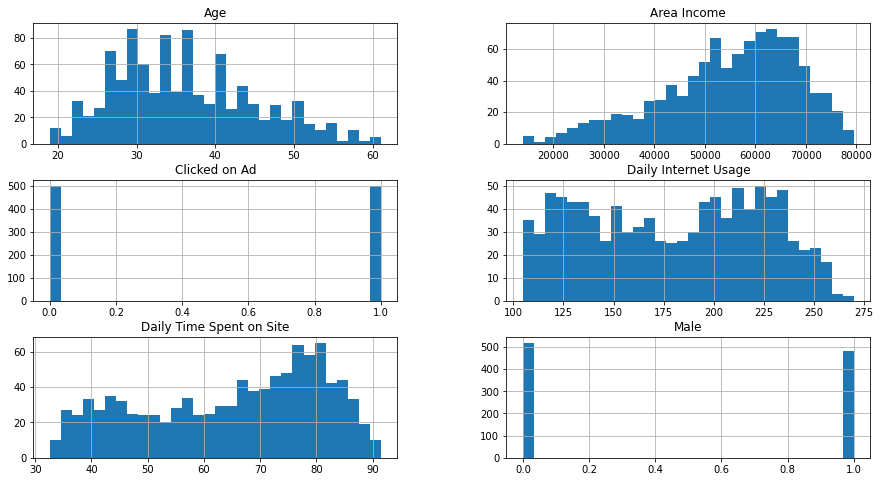

In [5]:
df.hist(bins=30 , figsize=(15,8))

1    500
0    500
Name: Clicked on Ad, dtype: int64


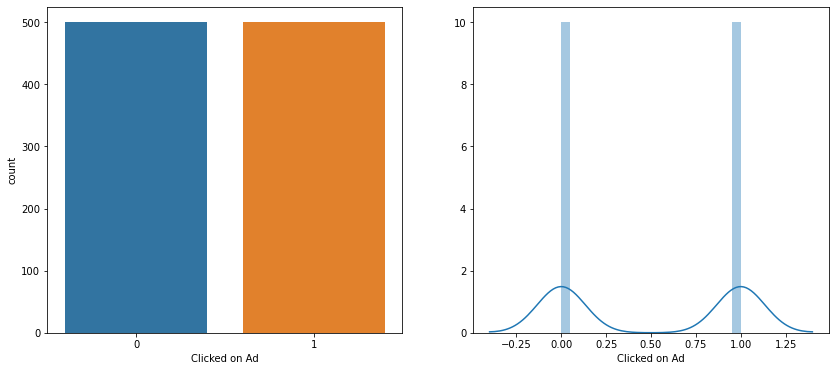

In [6]:
# Visualizing target variable Clicked on Ad
print(df["Clicked on Ad"].value_counts())
plt.figure(figsize = (14, 6)) 
plt.subplot(1,2,1)            
sns.countplot(x = 'Clicked on Ad', data = df)
plt.subplot(1,2,2)
sns.distplot(df["Clicked on Ad"], bins = 20)
plt.show()

##### => This shows that our data set has no class imbalance 

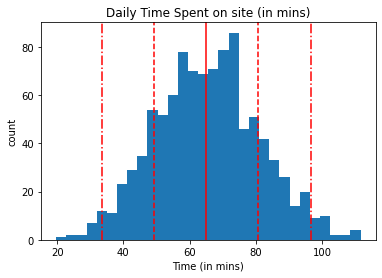

In [7]:
from scipy.stats import norm ,zscore
from numpy.random import seed
seed(47)
dailyTimeOnSite = norm.rvs(65, 15.8, size=1000)

_ = plt.hist(dailyTimeOnSite, bins=30)
_ = plt.xlabel('Time (in mins)')
_ = plt.ylabel('count')
_ = plt.title('Daily Time Spent on site (in mins)')
_ = plt.axvline(65, color='r')
_ = plt.axvline(65+15.8, color='r', linestyle='--')
_ = plt.axvline(65-15.8, color='r', linestyle='--')
_ = plt.axvline(65+(2*15.8), color='r', linestyle='-.')
_ = plt.axvline(65-(2*15.8), color='r', linestyle='-.')

### Check for nulls and duplicate entries

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


In [9]:
df.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

In [10]:
df.duplicated().sum()

0

We see that there are no null or dupicate entries 

### Investigate Numerical and Categorical Columns

In [11]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

In [12]:
#Actual categorical columns
df.select_dtypes(include = ['object']).columns

Index(['Ad Topic Line', 'City', 'Country', 'Timestamp'], dtype='object')

In [13]:
#Actual Numerical columns
df.select_dtypes(include = ['int64' , 'float64']).columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Male', 'Clicked on Ad'],
      dtype='object')

In [14]:
numeric_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage' ]
Categorical_cols = [ 'Ad Topic Line', 'City', 'Male', 'Country', 'Clicked on Ad' ]

In [15]:
df[numeric_cols].describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,65.000200,36.009000,55000.000080,180.000100
std,15.853615,8.785562,13414.634022,43.902339
min,32.600000,19.000000,13996.500000,104.780000
25%,51.360000,29.000000,47031.802500,138.830000
50%,68.215000,35.000000,57012.300000,183.130000
75%,78.547500,42.000000,65470.635000,218.792500
max,91.430000,61.000000,79484.800000,269.960000


In [16]:
df[Categorical_cols].describe(include = ['O']) # includes description of only the columns in Categorical_cols which are of object type 

,Ad Topic Line,City,Country
count,1000,1000,1000
unique,1000,969,237
top,Re-engineered context-sensitive knowledge user,Lisamouth,France
freq,1,3,9


In [17]:
pd.crosstab(df['Country'], df['Clicked on Ad']).sort_values(1,0,ascending = False).head(10)

Clicked on Ad,0,1
Country,,
Australia,1,7
Turkey,1,7
Ethiopia,0,7
Liberia,2,6
South Africa,2,6
Liechtenstein,0,6
Senegal,3,5
Peru,3,5
Mayotte,1,5


In [18]:
pd.crosstab(index=df['Country'],columns='count').sort_values(['count'], ascending=False).head(10)

col_0,count
Country,
France,9
Czech Republic,9
Afghanistan,8
Australia,8
Turkey,8
South Africa,8
Senegal,8
Peru,8
Micronesia,8


### INFERENCE :

We see that out of the 10 top countries that are more frequently occurring in the dataset , 
Australia , Turkey , South Africa ,Senegal , Peru have clicked on the Ads several times 

### Timestamp manipulations

In [19]:
# Extract datetime variables using timestamp column
df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
# Converting timestamp column into datatime object in order to extract new features
df['Month'] = df['Timestamp'].dt.month 
# Creates a new column called Month

df['Day'] = df['Timestamp'].dt.day     
# Creates a new column called Day

df['Hour'] = df['Timestamp'].dt.hour   # 24 hours time
# Creates a new column called Hour

df["Weekday"] = df['Timestamp'].dt.dayofweek 
# Creates a new column called Weekday with sunday as 6 and monday as 0
# Other way to create a weekday column
#df['weekday'] = df['Timestamp'].apply(lambda x: x.weekday()) # Monday 0 .. sunday 6

# df["Year"]=df['Timestamp'].dt.year
# df["Year"].unique() # Only 2016 is the year present - No need to create seperate column

# Dropping timestamp column to avoid redundancy
# df = df.drop(['Timestamp'], axis=1) # deleting timestamp

In [20]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Month,Day,Hour,Weekday
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,3,27,0,6
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,4,4,1,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,3,13,20,6
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,1,10,2,6
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,6,3,3,4


In [21]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'Month', 'Day', 'Hour', 'Weekday'],
      dtype='object')

In [22]:
subdf=df[["Daily Time Spent on Site","Daily Internet Usage","Clicked on Ad",'Hour']]
print(subdf.head())
grouped=subdf.groupby(by=["Hour"]).sum()
grouped.reset_index(level=0, inplace=True)
grouped.sort_values(by=["Clicked on Ad"] , ascending=False , inplace=True)
grouped

   Daily Time Spent on Site  Daily Internet Usage  Clicked on Ad  Hour
0                     68.95                256.09              0     0
1                     80.23                193.77              0     1
2                     69.47                236.50              0    20
3                     74.15                245.89              0     2
4                     68.37                225.58              0     3


,Hour,Daily Time Spent on Site,Daily Internet Usage,Clicked on Ad
9,9,3063.45,8585.39,28
7,7,3611.43,9799.68,26
0,0,2855.80,7775.86,26
18,18,2605.11,7214.42,25
11,11,2590.39,6829.87,24
20,20,3285.16,9488.26,24
3,3,2733.83,7314.17,23
6,6,2390.66,6810.24,23
17,17,2533.81,7227.43,23
4,4,2787.52,7632.61,21


Text(0.5, 1.0, 'Hourly Site Usage')

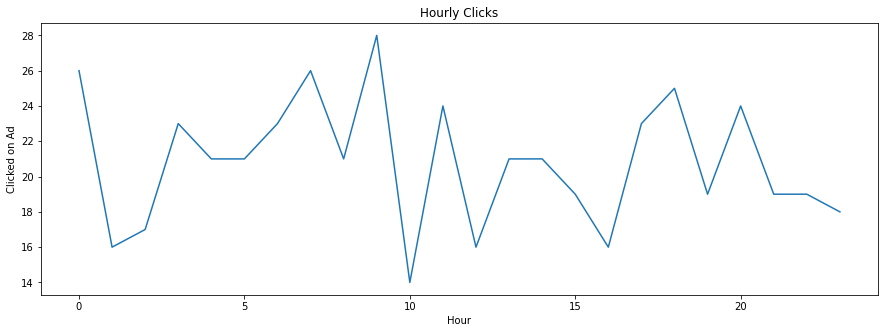

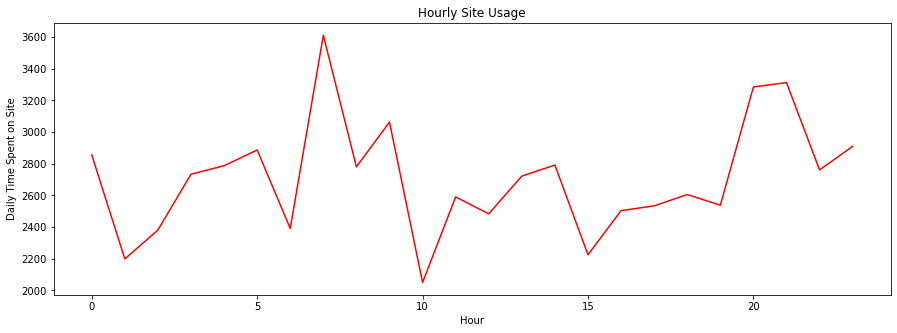

In [23]:
fig,ax1=plt.subplots(figsize=(15,5))
sns.lineplot(x="Hour",y="Clicked on Ad",data=grouped ,ax=ax1  ).set_title("Hourly Clicks")

fig,ax2=plt.subplots(figsize=(15,5))
sns.lineplot(x="Hour",y="Daily Time Spent on Site",data=grouped, ax=ax2, color='r' ).set_title("Hourly Site Usage")


### INFERENCE :
Here we can see that the maximum number of clicks are at 9 am , followed by 7 am and 12 am , then by 6pm (18 hrs) , then by 11am irrespective of site usage

Text(0.5, 1.0, 'Hourly Site usage - Not Clicked')

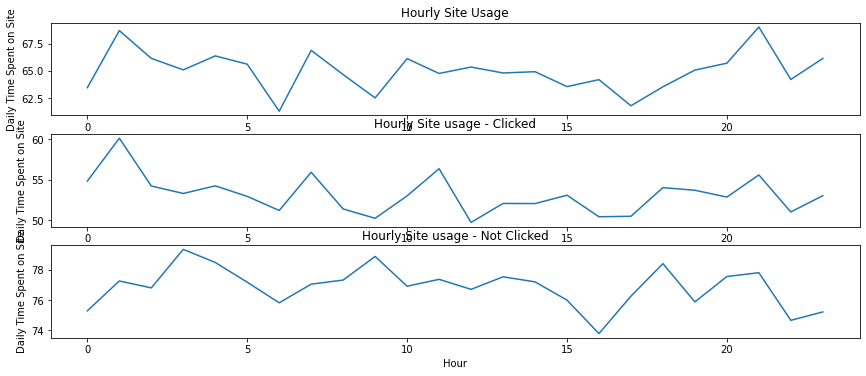

In [24]:
#Visualizing Time spent on Site vs Clicks 

fig, ax = plt.subplots(figsize=(15,8),sharey=True)
fig.tight_layout(pad=12) # To give padding between subplots
clicked=df[df['Clicked on Ad']==1]
notClicked=df[df['Clicked on Ad']==0]

plt.subplot(3,1,1)
sns.lineplot(x="Hour",y="Daily Time Spent on Site",data=df , ci=None ).set_title("Hourly Site Usage")

plt.subplot(3,1,2)
sns.lineplot(x="Hour",y="Daily Time Spent on Site",data=clicked , ci=None ).set_title("Hourly Site usage - Clicked")

plt.subplot(3,1,3)
sns.lineplot(x="Hour",y="Daily Time Spent on Site",data=notClicked , ci=None  ).set_title("Hourly Site usage - Not Clicked")


# sns.lineplot(x="Hour",y="Daily Time Spent on Site",data=clicked ,ax=ax ,hue="Clicked on Ad",style="Clicked on Ad",
#     markers=True, dashes=False).set_title("Hourly Site Usage")

### AD LENGTH VS CLICKS 

In [25]:
df.head()
df['AdLength']=df['Ad Topic Line'].str.len()
df.head()


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Month,Day,Hour,Weekday,AdLength
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,3,27,0,6,34
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,4,4,1,0,34
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,3,13,20,6,32
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,1,10,2,6,37
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,6,3,3,4,29


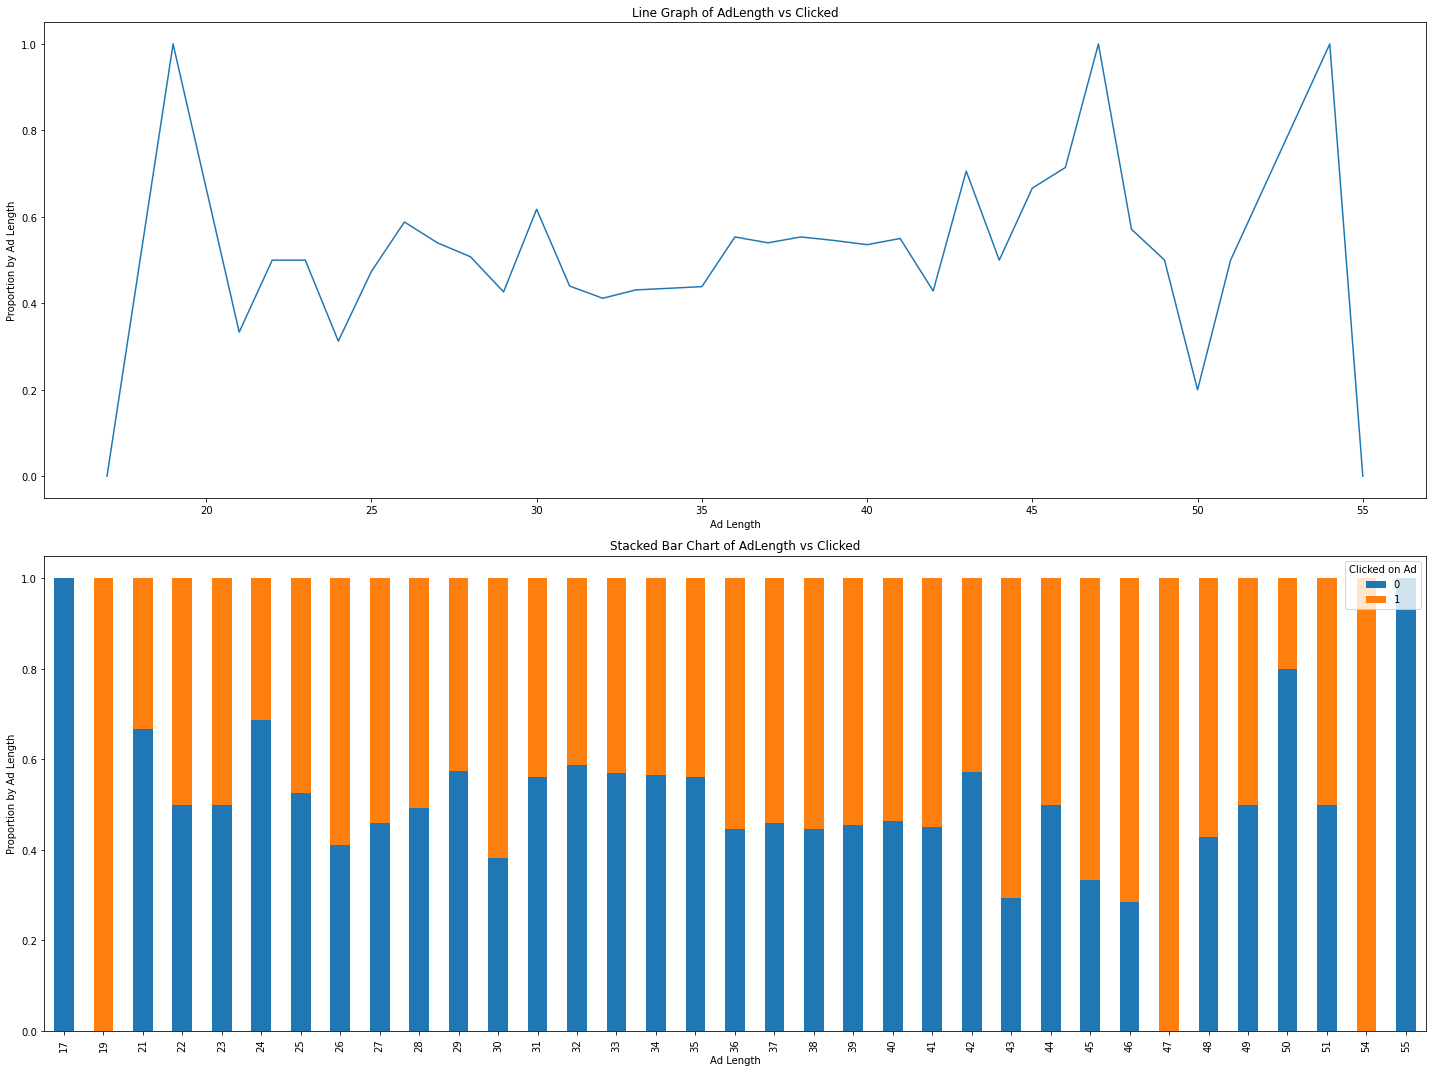

In [26]:
f,ax=plt.subplots(2,1,figsize=(20,15))
#Line Chart
sns.lineplot(x="AdLength",y="Clicked on Ad",data=df ,ax=ax[0] ,ci=None).set_title("Ad Length Effect")
ax[0].set_title('Line Graph of AdLength vs Clicked')
ax[0].set_ylabel('Proportion by Ad Length')
ax[0].set_xlabel('Ad Length')

#Stacked Bar Graph
table = pd.crosstab(df['AdLength'],df['Clicked on Ad'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=ax[1], grid = False)
ax[1].set_title('Stacked Bar Chart of AdLength vs Clicked')
ax[1].set_ylabel('Proportion by Ad Length')
ax[1].set_xlabel('Ad Length')

plt.tight_layout()
plt.show()

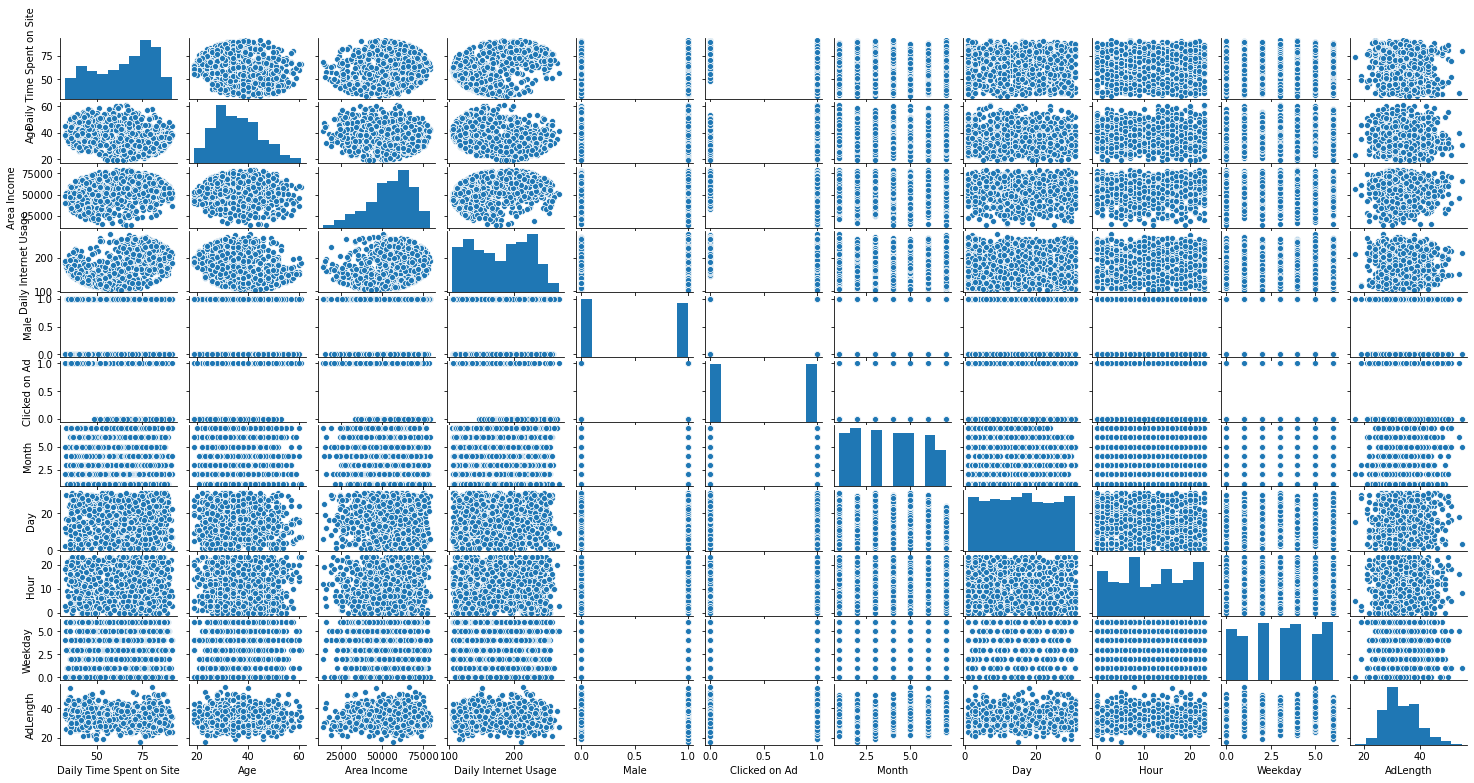

In [27]:
g=sns.pairplot(df)
g.fig.set_figheight(10)
g.fig.set_figwidth(20)

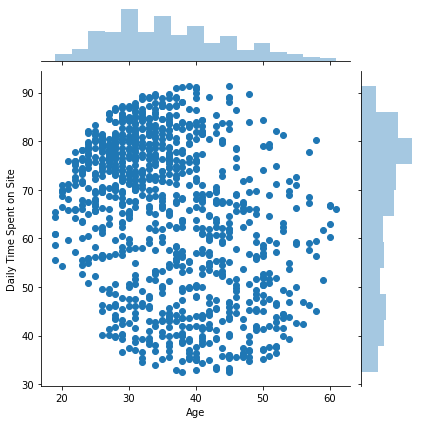

In [28]:
# Jointplot of daily time spent on site and age
sns.jointplot(x = "Age", y= "Daily Time Spent on Site", data = df) 

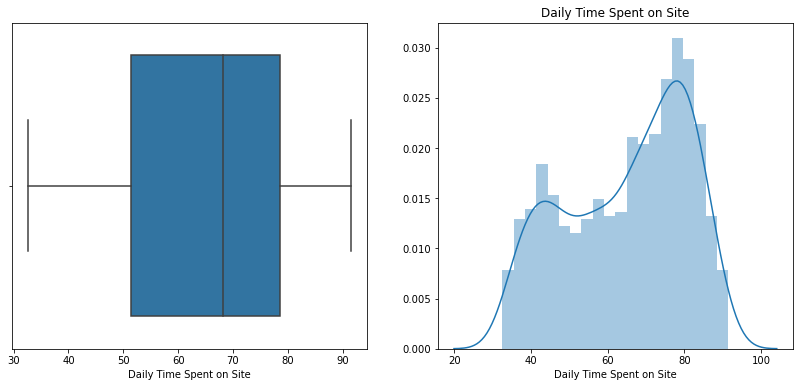

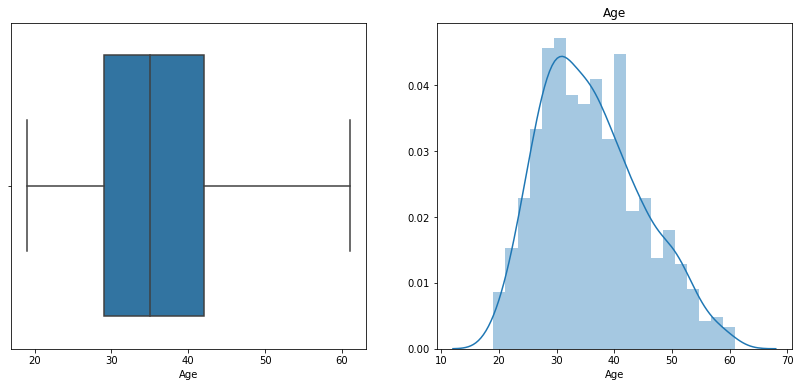

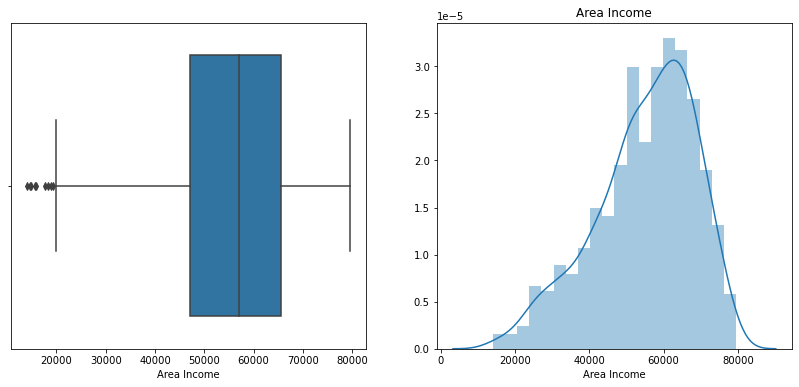

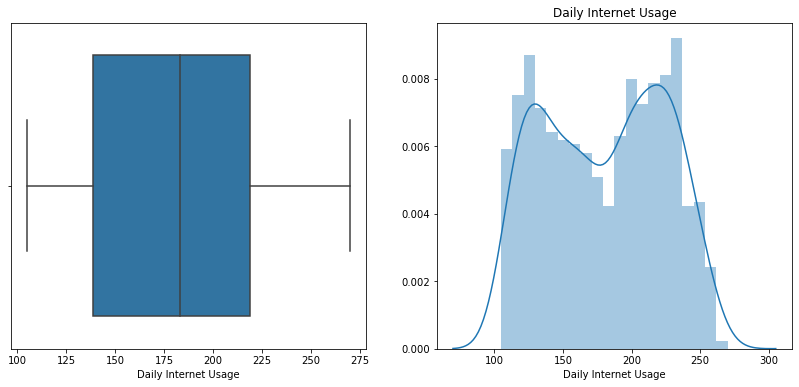

In [29]:
plots = ['Daily Time Spent on Site', 'Age', 'Area Income','Daily Internet Usage']
for i in plots:
    plt.figure(figsize = (14, 6))
    
    plt.subplot(1,2,1)
    sns.boxplot(df[i])
    
    plt.subplot(1,2,2)
    sns.distplot(df[i],bins= 20)  # The seaborn equivalent to a pandas histogram is the distplot
    
    plt.title(i)    
    plt.show()

In [30]:
print('oldest person was of:', df['Age'].max(), 'Years')
print('Youngest person was of:', df['Age'].min(), 'Years')
print('Average age was of:', df['Age'].mean(), 'Years')

oldest person was of: 61 Years
Youngest person was of: 19 Years
Average age was of: 36.009 Years


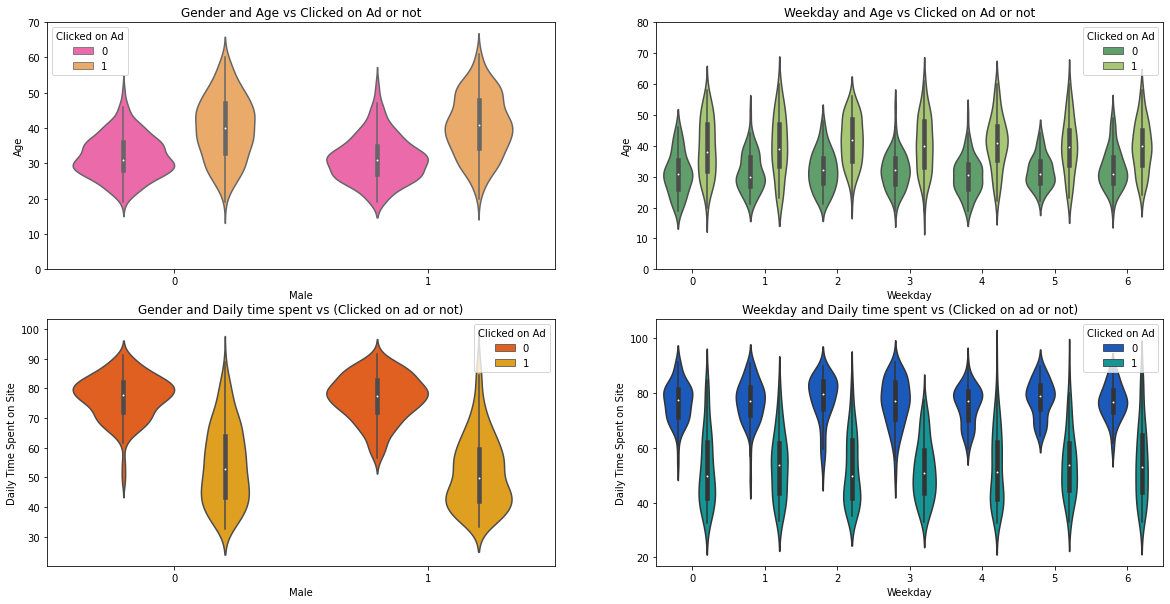

In [31]:
f,ax=plt.subplots(2,2, figsize=(20,10))
sns.violinplot("Male","Age", hue= "Clicked on Ad", data=df,ax=ax[0,0],palette="spring" )
ax[0,0].set_title('Gender and Age vs Clicked on Ad or not')
ax[0,0].set_yticks(range(0,80,10))

sns.violinplot("Weekday","Age", hue="Clicked on Ad", data=df,ax=ax[0,1],palette="summer" )
ax[0,1].set_title('Weekday and Age vs Clicked on Ad or not')
ax[0,1].set_yticks(range(0,90,10))

sns.violinplot("Male","Daily Time Spent on Site", hue="Clicked on Ad", data=df,ax=ax[1,0],palette="autumn" )
ax[1,0].set_title('Gender and Daily time spent vs (Clicked on ad or not)')
# ax[1,0].set_yticks(range(0,120,10))

sns.violinplot("Weekday","Daily Time Spent on Site", hue="Clicked on Ad", data=df,ax=ax[1,1],palette="winter" )
ax[1,1].set_title('Weekday and Daily time spent vs (Clicked on ad or not)')
# ax[1,1].set_yticks(range(0,120,10))

plt.show()

#### Inferences from the Violin plots :

 [0,0]   1) Male and Female of age group 32-48 years tend to click the ad with the median age being 40 years
 
 [1,0]   2) Male and Female of who spend 70-95 mins do not click on the add 
       Females who spend 42-65 mins are more likely to click through , basically around an hour
       Males who spend 42-60 mins are more likely to click through 


In [32]:
df.groupby('Clicked on Ad')['Clicked on Ad', 'Daily Time Spent on Site', 'Age', 'Area Income', 
                            'Daily Internet Usage'].mean()

<ipython-input-32-bbfe82a2ec24>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('Clicked on Ad')['Clicked on Ad', 'Daily Time Spent on Site', 'Age', 'Area Income',


,Clicked on Ad,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
Clicked on Ad,,,,,
0,0.0,76.85462,31.684,61385.58642,214.51374
1,1.0,53.14578,40.334,48614.41374,145.48646


In [33]:
df.groupby(['Male','Clicked on Ad'])['Clicked on Ad'].count().unstack()

Clicked on Ad,0,1
Male,,
0,250,269
1,250,231


### Checking Outliers :

In [34]:
for i in numeric_cols:
    stat = df[i].describe()
    print("STAT --- ",stat,"---")
    IQR = stat['75%'] - stat['25%']
    upper = stat['75%'] + 1.5 * IQR
    lower = stat['25%'] - 1.5 * IQR
    print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

STAT ---  count    1000.000000
mean       65.000200
std        15.853615
min        32.600000
25%        51.360000
50%        68.215000
75%        78.547500
max        91.430000
Name: Daily Time Spent on Site, dtype: float64 ---
The upper and lower bounds for suspected outliers are 119.32875 and 10.57875.
STAT ---  count    1000.000000
mean       36.009000
std         8.785562
min        19.000000
25%        29.000000
50%        35.000000
75%        42.000000
max        61.000000
Name: Age, dtype: float64 ---
The upper and lower bounds for suspected outliers are 61.5 and 9.5.
STAT ---  count     1000.000000
mean     55000.000080
std      13414.634022
min      13996.500000
25%      47031.802500
50%      57012.300000
75%      65470.635000
max      79484.800000
Name: Area Income, dtype: float64 ---
The upper and lower bounds for suspected outliers are 93128.88375000001 and 19373.553749999992.
STAT ---  count    1000.000000
mean      180.000100
std        43.902339
min       104.780000
25%

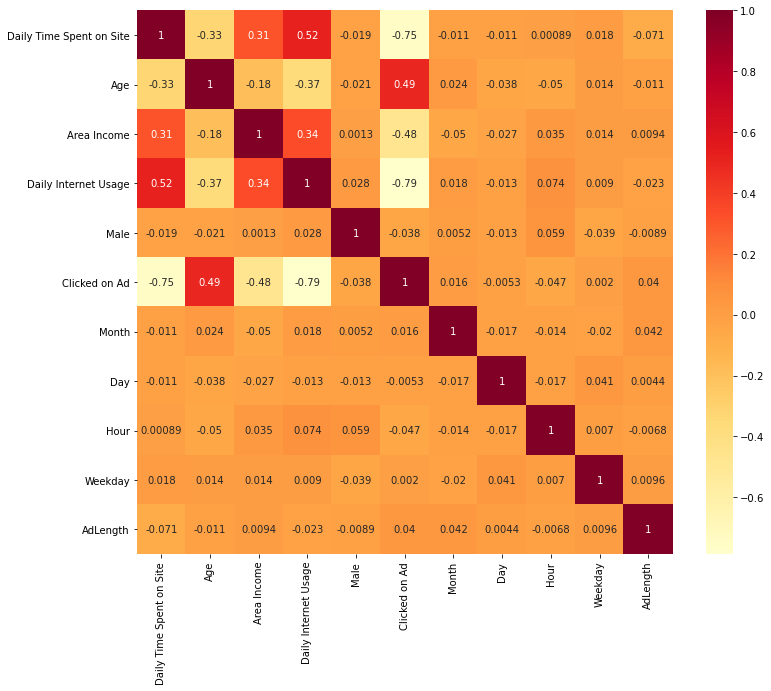

In [35]:
fig = plt.figure(figsize = (12,10))
sns.heatmap(df.corr(), cmap='YlOrRd', annot = True) # Degree of relationship i.e correlation using heatmap

Clicked on Ad   0   1
Month                
1              78  69
2              77  83
3              82  74
4              73  74
5              68  79
6              71  71
7              51  50


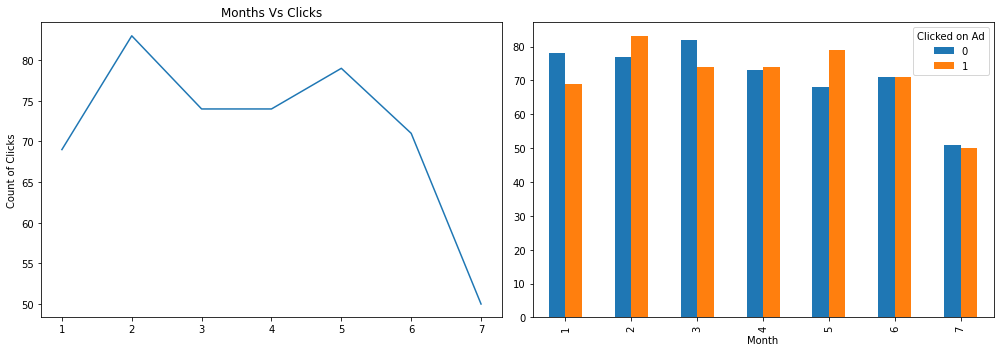

Month
1    69
2    83
3    74
4    74
5    79
6    71
7    50
Name: Clicked on Ad, dtype: int64


In [36]:
f,ax=plt.subplots(1,2,figsize=(14,5))
df['Month'][df['Clicked on Ad']==1].value_counts().sort_index().plot(ax=ax[0])
ax[0].set_title('Months Vs Clicks')
ax[0].set_ylabel('Count of Clicks')
print(pd.crosstab(df["Clicked on Ad"], df["Month"]).T)
pd.crosstab(df["Clicked on Ad"], df["Month"]).T.plot(kind = 'bar',ax=ax[1])
plt.tight_layout()
plt.show()
print(df.groupby(['Month'])['Clicked on Ad'].sum())

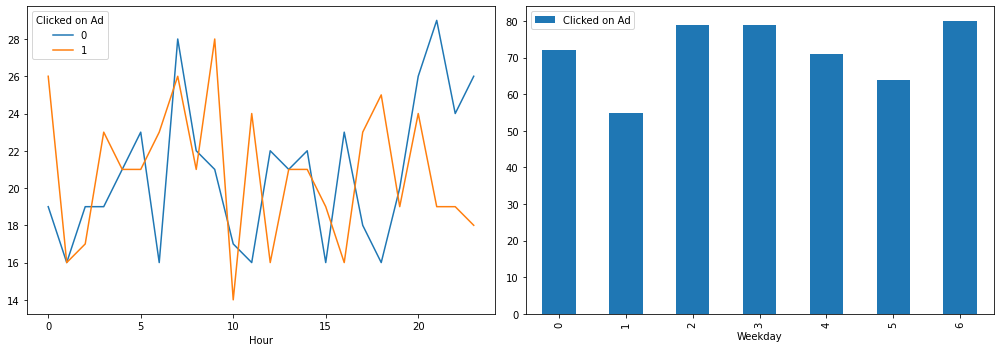

In [37]:
f,ax=plt.subplots(1,2,figsize=(14,5))
pd.crosstab(df["Clicked on Ad"], df["Hour"]).T.plot(style = [], ax = ax[0])
pd.pivot_table(df, index = ['Weekday'], values = ['Clicked on Ad'],aggfunc= np.sum).plot(kind = 'bar', ax=ax[1]) # 0 - Monday
plt.tight_layout()
plt.show()

In [38]:
# hdf = pd.pivot_table(df, index = ['Hour'], columns = ['Male'], values = ['Clicked on Ad'], 
#                      aggfunc= np.sum).rename(columns = {'Clicked on Ad':'Clicked'})

# cm = sns.light_palette("yellow", as_cmap=True)
# hdf.style.background_gradient(cmap=cm)  # Sums all 1's i.e clicked for each hour

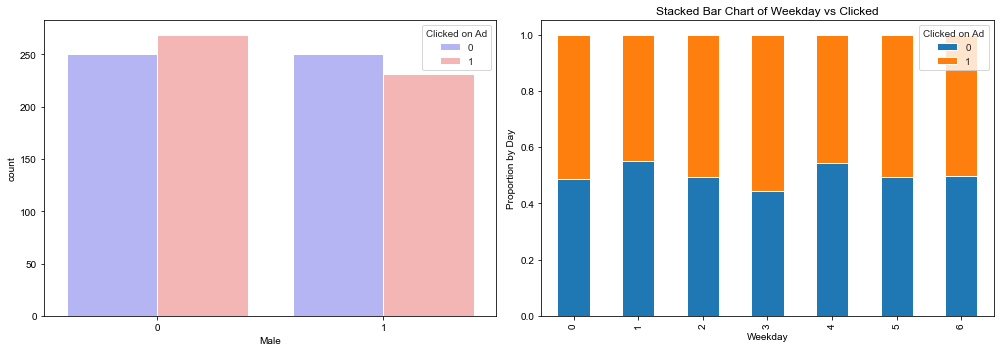

In [39]:
f,ax=plt.subplots(1,2,figsize=(14,5))
sns.set_style('whitegrid')
sns.countplot(x='Male',hue='Clicked on Ad',data=df,palette='bwr', ax = ax[0]) # Overall distribution of Males and females count
table = pd.crosstab(df['Weekday'],df['Clicked on Ad'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=ax[1], grid = False) # 0 - Monday
ax[1].set_title('Stacked Bar Chart of Weekday vs Clicked')
ax[1].set_ylabel('Proportion by Day')
ax[1].set_xlabel('Weekday')
plt.tight_layout()
plt.show()

c:\users\monika\py3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\monika\py3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


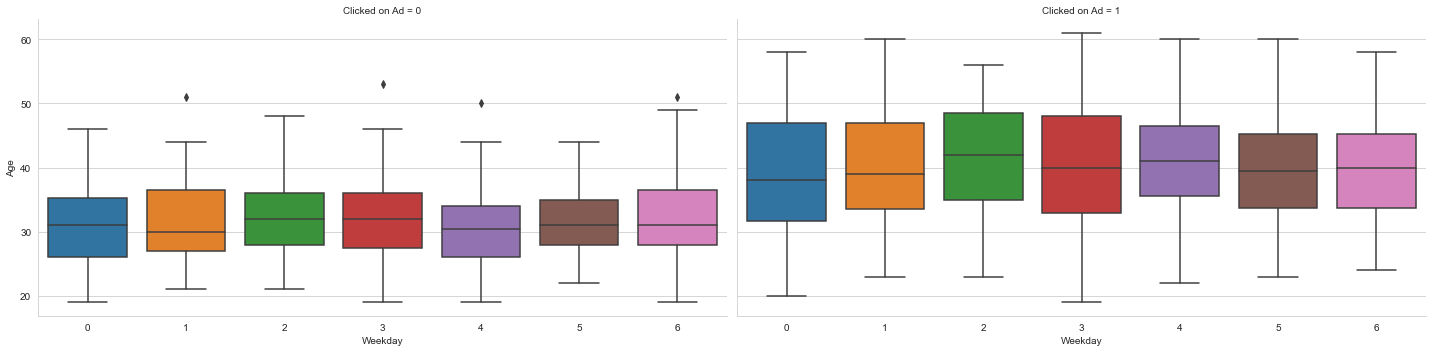

In [40]:
sns.factorplot(x="Weekday", y="Age", col="Clicked on Ad", data=df, kind="box",size=5, aspect=2.0) 

c:\users\monika\py3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


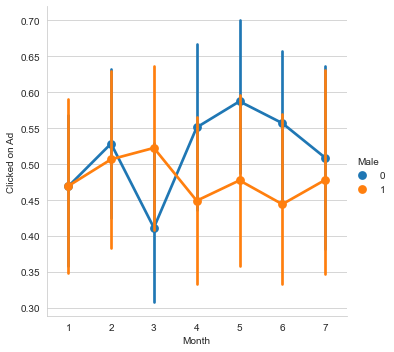

In [41]:
sns.factorplot('Month', 'Clicked on Ad', hue='Male', data = df)
plt.show()

In [42]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'Month', 'Day', 'Hour', 'Weekday',
       'AdLength'],
      dtype='object')

# MODELLING

In [43]:
from sklearn.model_selection import train_test_split
X = df[['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male']]
y = df['Clicked on Ad']

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
scaler = StandardScaler()
logreg = LogisticRegression()
steps = [('scaler',scaler),("Logistic",logreg)]
pipeline = Pipeline(steps)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 5) (700,)
(300, 5) (300,)


In [46]:
pipeline.fit(X_train,y_train)
preds=pipeline.predict(X_test)
pipeline.score(X_test,y_test)

0.97

### METRICS 

In [50]:
# Classification Report 
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       146
           1       0.98      0.96      0.97       154

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [48]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, preds))

[[143   3]
 [  6 148]]


### RANDOM FOREST CLASSIFIER

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 9, num = 5)]
rf_grid = {'n_estimators':n_estimators,
              'criterion':criterion,
              'max_depth':max_depth}
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf,rf_grid,cv=5, verbose=2)
rf_cv.fit(X_train, y_train)
print(rf_cv.best_score_, rf_cv.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] criterion=gini, max_depth=1, n_estimators=200 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... criterion=gini, max_depth=1, n_estimators=200, total=   1.2s
[CV] criterion=gini, max_depth=1, n_estimators=200 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .... criterion=gini, max_depth=1, n_estimators=200, total=   0.5s
[CV] criterion=gini, max_depth=1, n_estimators=200 ...................
[CV] .... criterion=gini, max_depth=1, n_estimators=200, total=   0.4s
[CV] criterion=gini, max_depth=1, n_estimators=200 ...................
[CV] .... criterion=gini, max_depth=1, n_estimators=200, total=   0.4s
[CV] criterion=gini, max_depth=1, n_estimators=200 ...................
[CV] .... criterion=gini, max_depth=1, n_estimators=200, total=   0.7s
[CV] criterion=gini, max_depth=1, n_estimators=400 ...................
[CV] .... criterion=gini, max_depth=1, n_estimators=400, total=   0.9s
[CV] criterion=gini, max_depth=1, n_estimators=400 ...................
[CV] .... criterion=gini, max_depth=1, n_estimators=400, total=   0.7s
[CV] criterion=gini, max_depth=1, n_estimators=400 ...................
[CV] .... criterion=gini, max_depth=1, n_estimators=400, total=   0.9s
[CV] criterion=gini, max_depth=1, n_estimators=400 ...................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  6.6min finished


0.962857142857143 {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 200}


In [55]:
rf_test = RandomForestClassifier(
    n_estimators = 400, 
    criterion = 'entropy',
    max_depth = 5)
rf_test.fit(X_train, y_train)
print(rf_test.score(X_test, y_test))

0.9533333333333334


5


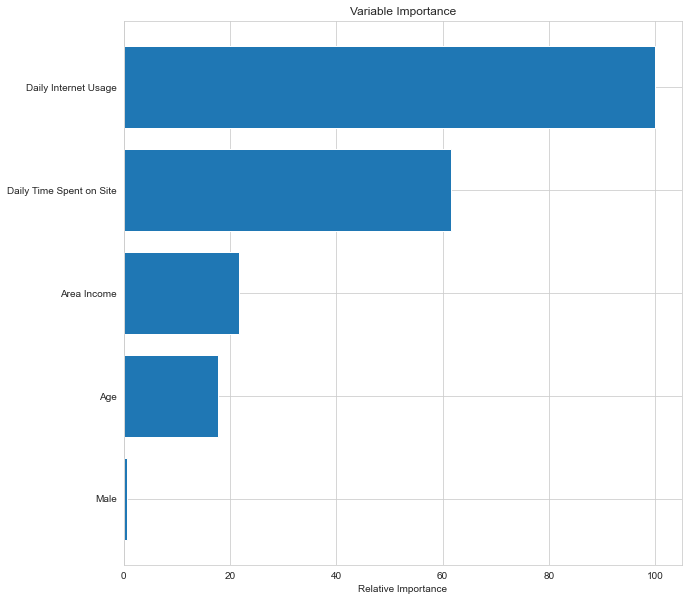

In [56]:
feature_importance = rf_test.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0])
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()